In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import OrderedDict

%matplotlib inline

# Target

$$ f(x,y) = \frac{1}{20}x^{2} + y^{2} $$

In [2]:
_x = np.linspace(-2,2,100)
_y = np.linspace(-2,2,100)

x0, y0 = np.meshgrid(_x, _y)

def target_func(x, y):
    return x ** 2 / 20 + y ** 2

z = target_func(x0, y0)
print(z.shape)

(100, 100)


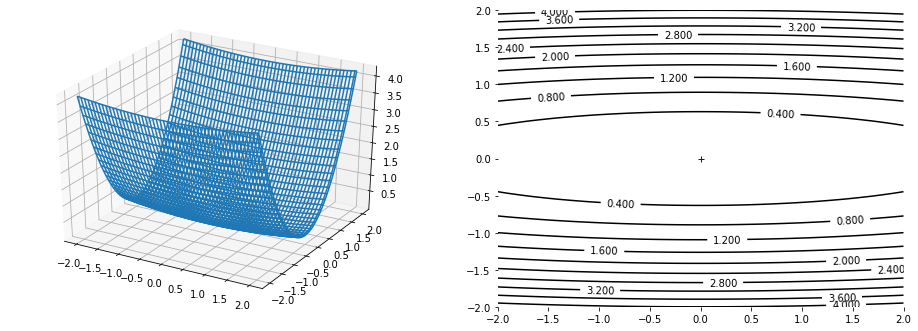

In [3]:
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(12)
ax = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, frameon=False)

# Plot a basic wireframe.
ax.plot_wireframe(x0, y0, z)

#ax2.contourf(x0, y0, z, 20, cmap=plt.cm.hot)
m = ax2.contour(x0, y0, z, 12, colors = 'black')
plt.clabel(m, inline = True, fontsize = 10)
ax2.plot(np.array([0]),np.array([0]), "b+")

plt.show()

# Update Parameters

## SGD

$$ W \leftarrow W - \eta\frac{\partial L}{\partial W} $$

In [4]:
class SGD:
    def __init__(self, lr=1e-2):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## Momentum

$$ v \leftarrow \alpha v - \eta\frac{\partial L}{\partial W} $$
$$ W \leftarrow W + v $$

In [5]:
class Momentum:
    def __init__(self, lr=1e-2, momentum=9e-1):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v == None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key, val in params.items():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

## AdaGrad

$$ h \leftarrow h + \frac{\partial L}{\partial W} \cdot \frac{\partial L}{\partial W} $$
$$ W \leftarrow W + \eta * \frac{1}{\sqrt{h}} * \frac{\partial L}{\partial W} $$

In [6]:
class AdaGrad:
    def __init__(self, lr=1e-2):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h == None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key, val in params.items():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr / np.sqrt(self.h[key] + 1e-7) * grads[key]

## Adam

$$ Iter:\ The\ iteration\ number $$
$$ \eta \leftarrow \eta * \frac{\sqrt{1 - \beta_2^{Iter}}}{1 - \beta_1^{Iter}} $$
$$ m \leftarrow m + (1 - \beta_1) * (\frac{\partial L}{\partial W} - m) $$
$$ v \leftarrow v + (1 - \beta_2) * (\frac{\partial L}{\partial W} \cdot \frac{\partial L}{\partial W} - v) $$
$$ W \leftarrow W + \eta * \frac{m}{\sqrt{v}} $$

In [7]:
class Adam:
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.999):
        self.m = None
        self.v = None
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
    
    def update(self, params, grads):
        if self.m == None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
                
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)
        
        for key, val in params.items():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * (self.m[key] / (np.sqrt(self.v[key] + 1e-7)) )

## Compare

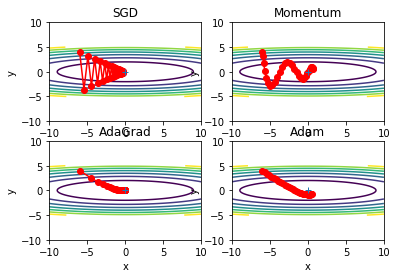

In [8]:
def df(x, y):
    return x / 10.0, 2.0 * y

init_pos = (-6.0, 4.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

opts = OrderedDict()
opts["SGD"] = SGD(lr=0.95)
opts["Momentum"] = Momentum(lr=0.1)
opts["AdaGrad"] = AdaGrad(lr=1.5)
opts["Adam"] = Adam(lr=0.3)

idx = 1
for key, _ in opts.items():
    # initializations
    opt = opts[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        grads['x'], grads['y'] = df(params['x'], params['y'])
        opt.update(params, grads)
        
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    X, Y = np.meshgrid(x, y)
    Z = target_func(X, Y)
    
    # plot
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.show()

# Weights and Parameters

## Weight Parameters

The weight is better not to set to 0. In backpropagation, the weight might be set to the same value (in some methods).

## Activation among Hidden Layers (Sigmoid and Tanh)

use **Xavier** algorithm to set weights while using **Sigmoid** or **Tanh** as the activation function

### Standard Deviation

In [9]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

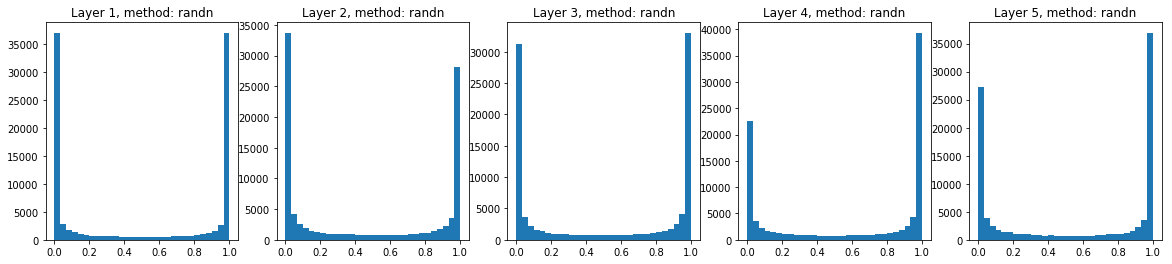

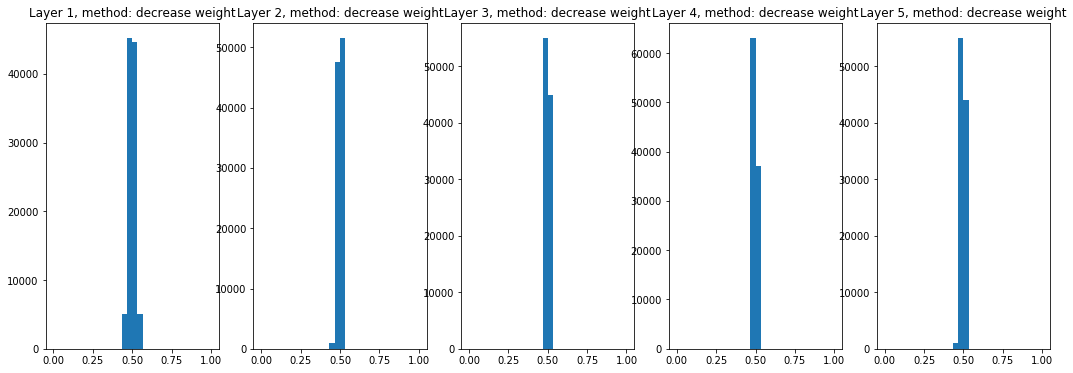

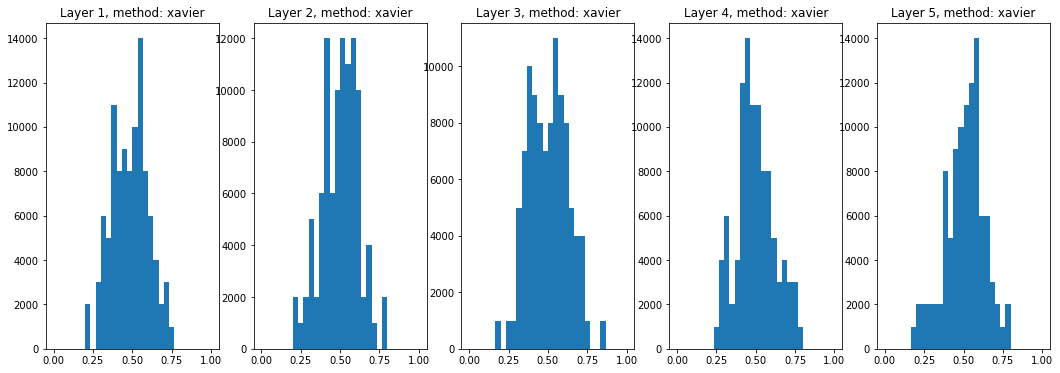

In [12]:
x = np.random.randn(1000, 100)   # assume 1000 data, map to 100 nodes
node_num = 100  # assume there are 100 hidden nodes in each layer
hidden_layers = 5  # assume there are 5 hidden layers
activation = {}  # save the activation result of each hidden layer

newstd = { "randn": 1, "decrease weight": 100, "xavier": np.sqrt(node_num) }
for mtd, val in newstd.items():
    for i in range(hidden_layers):
        if i != 0:
            x = activation[i-1]

        #W = np.random.randn(node_num, node_num) * 1  # nothing to weights, but might cause gradient vanishing
        #W = np.random.randn(node_num, node_num) * 0.01  # decrease the std, but loss expression
        #W = np.random.randn(node_num, node_num) / np.sqrt(node_num)  # xavier
        W = np.random.randn(node_num, node_num) / val

        Z = np.dot(x, W)
        a = sigmoid(Z)
        activation[i] = a

    for lay, act in activation.items():
        plt.subplot(1, len(activation), lay+1)
        plt.title("Layer " + str(lay + 1) + ", method: " + mtd)
        plt.rcParams["figure.figsize"] = [18,6]
        plt.hist(act.flatten(), 30, range=(0,1))
    plt.show()

### Xavier Standard

$$ new\ standard\ deviation = \sqrt{\frac{1}{n}} $$

```python
for i in range(hidden_layers):
    if i != 0:
        x = activation[i-1]
        
    #W = np.random.randn(node_num, node_num) * 1  # nothing to weights, but might cause gradient vanishing
    #W = np.random.randn(node_num, node_num) * 0.01  # decrease the std, but loss expression
    W = np.random.randn(node_num, node_num) / np.sqrt(node_num)  # xavier
    
    Z = np.dot(x, W)
    a = sigmoid(Z)
    activation[i] = a
```

## Activation among Hidden Layers (ReLu)

use **He** algorithm to set weights instead of xavier while using **relu** as the activation function

$$ Kaiming\ He : new\ standard\ deviation = \sqrt{\frac{2}{n}} $$

```python
for i in range(hidden_layers):
    if i != 0:
        x = activation[i-1]
        
    #W = np.random.randn(node_num, node_num) * 1  # nothing to weights, but might cause gradient vanishing
    #W = np.random.randn(node_num, node_num) * 0.01  # decrease the std, but loss expression
    #W = np.random.randn(node_num, node_num) / np.sqrt(node_num)  # Xavier
    W = np.random.randn(node_num, node_num) / np.sqrt(2.0 / node_num)  # He
    
    Z = np.dot(x, W)
    a = sigmoid(Z)
    activation[i] = a
```

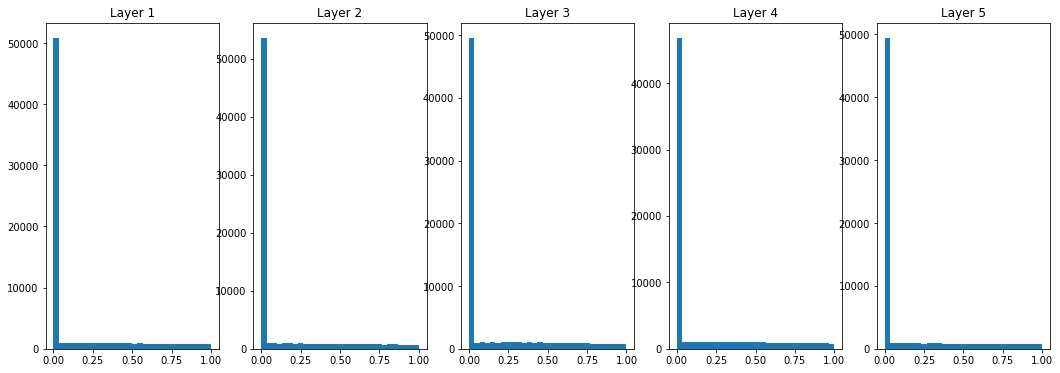

In [11]:
def relu(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 100)   # assume 1000 data, map to 100 nodes
node_num = 100  # assume there are 100 hidden nodes in each layer
hidden_layers = 5  # assume there are 5 hidden layers
activation = {}  # save the activation result of each hidden layer

for i in range(hidden_layers):
    if i != 0:
        x = activation[i-1]

    #W = np.random.randn(node_num, node_num) * 0.01
    #W = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    W = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    Z = np.dot(x, W)
    a = relu(Z)
    activation[i] = a

for lay, act in activation.items():
    plt.subplot(1, len(activation), lay+1)
    plt.title("Layer " + str(lay + 1))
    plt.rcParams["figure.figsize"] = [20,4]
    plt.hist(act.flatten(), 30, range=(0,1))
plt.show()

# Batch Normalization

$$ \mu_{B} \leftarrow \frac{1}{m} \sum^{m}_{i=1} x_i $$
$$ \sigma^{2}_{B} \leftarrow \frac{1}{m} \sum^{m}_{i=1} (x_i - \mu_B)^2 $$
$$ \widehat x_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \varepsilon}} $$

In [23]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # Conv層の場合は4次元、全結合層の場合は2次元  

        # テスト時に使用する平均と分散
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward時に使用する中間データ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

# Overfitting and Normalization

## weight decay (regularization)

$$ L2\ norm=\frac{1}{2} * \lambda * W^2 $$

```python
def loss(x, t):
    y = predict(x)

    # +2 : include input, output
    for idx in range(1, hidden_layer_num + 2):
        W = params['W' + str(idx)]
        # L2 norm
        weight_decay += 0.5 * weight_decay_lambda * np.sum(W ** 2)

    return last_layer.forward(y, t) + weight_decay
```

## dropout

In [25]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, training_flag=True):
        if training_flag:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
            
    def backward(self, dout):
        return dout * self.mask

# Hyperparameters

## validation data (different from test data)

## hyper-parameters optimizations
* Step.1 : Set the range of all parameters.
* Step.2 : Random sampling
* Step.3 : Random set parameters based on Step.1
* Step.4 : Using less epochs to validate (adjust)
* Step.5 : Narrow the range and back to Step.1